<a href="https://colab.research.google.com/github/fibleep/michael-cera-detector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

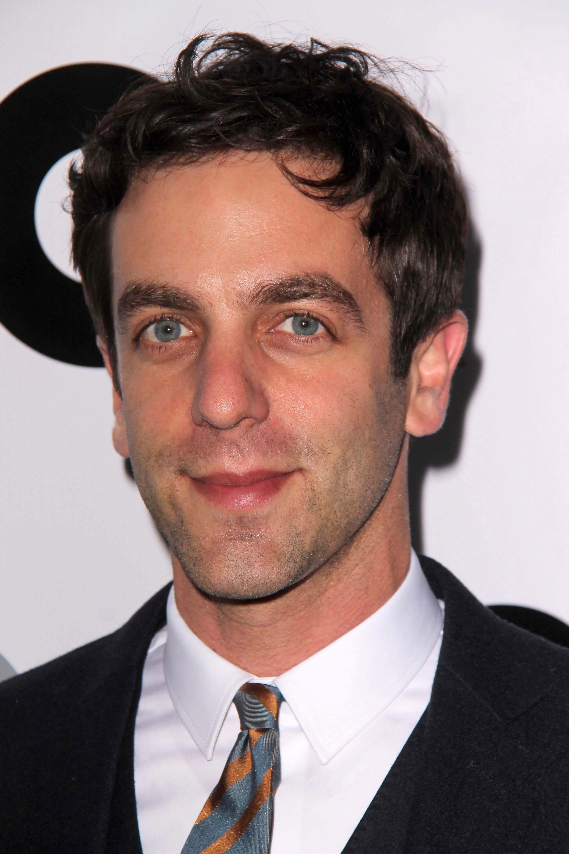

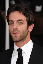

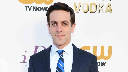

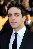

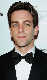

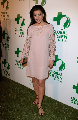

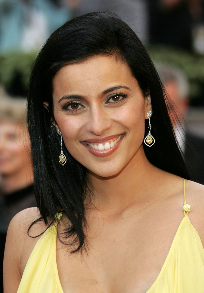

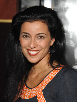

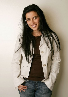

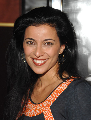

In [18]:
import os
import cv2
import tarfile
import numpy as np
from urllib import request
from google.colab import drive
from google.colab.patches import cv2_imshow


base_path = "/content/sample_data/CV__Group_assignment"

if not os.path.isdir(base_path):
  os.makedirs(base_path)

vgg_face_dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz"

with request.urlopen(vgg_face_dataset_url) as r, open(os.path.join(base_path, "vgg_face_dataset.tar.gz"), 'wb') as f:
  f.write(r.read())

with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
  f.extractall(os.path.join(base_path))

trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
    f.write(r.read())


all_subjects = [subject for subject in sorted(os.listdir(os.path.join(base_path, "vgg_face_dataset", "files"))) if subject.startswith("B") and subject.endswith(".txt")]

nb_subjects = 2
nb_images_per_subject = 5

images = []
for subject in all_subjects[:nb_subjects]:

  with open(os.path.join(base_path, "vgg_face_dataset", "files", subject), 'r') as f:
    lines = f.readlines()

  images_ = []
  for line in lines:
    url = line[line.find("http://"): line.find(".jpg") + 4]

    try:
      res = request.urlopen(url)
      img = np.asarray(bytearray(res.read()), dtype="uint8")
      img = cv2.imdecode(img, cv2.IMREAD_COLOR)
      h, w = img.shape[:2]
      images_.append(img)
      cv2_imshow(cv2.resize(img, (w // 5, h // 5)))

    except:
      pass

    if len(images_) == nb_images_per_subject:
      images.append(images_)
      break

Found 1 face(s)!


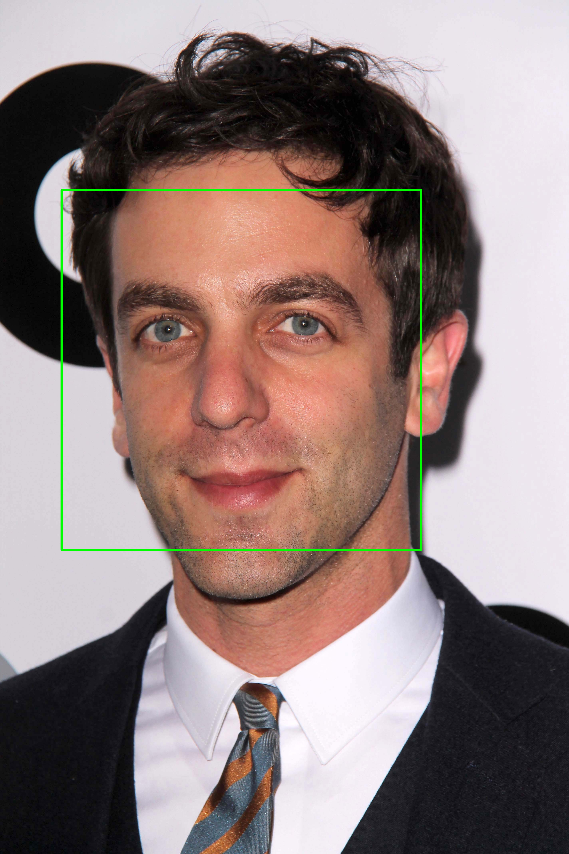

Found 1 face(s)!


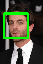

Found 1 face(s)!


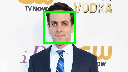

Found 1 face(s)!


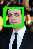

Found 1 face(s)!


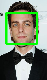

Found 1 face(s)!


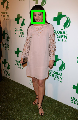

Found 1 face(s)!


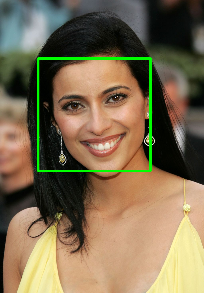

Found 1 face(s)!


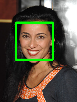

Found 1 face(s)!


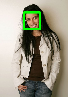

Found 1 face(s)!


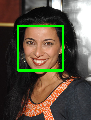

In [19]:
faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))

for images_ in images:

  for img in images_:

    img_ = img.copy()
    img_gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        img_gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    print("Found {} face(s)!".format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(img_, (x, y), (x+w, y+h), (0, 255, 0), 10)

    h, w = img_.shape[:2]

    cv2_imshow(cv2.resize(img_, (w // 5, h // 5)))

# Implementing Transfer Learning for Michael Cera detection

Get the dataset

In [20]:
!git clone https://github.com/fibleep/michael-cera-detector.git

fatal: destination path 'michael-cera-detector' already exists and is not an empty directory.


In [30]:
import keras
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

directory = '/content/michael-cera-detector/dataset'

# Keras Image Data Generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize the pixels
    rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.2,  # Range for random horizontal shifts
    height_shift_range=0.2, # Range for random vertical shifts
    shear_range=0.2,        # Shear angle in counter-clockwise direction
    zoom_range=0.2,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
batch_size = 128 # How many images loaded in at once
target_size = (224, 224)  # Image dimensions

# Create a generator for reading images from the directory
train_imgs = train_datagen.flow_from_directory(
    directory + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_imgs = test_datagen.flow_from_directory(
    directory + "/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_imgs = test_datagen.flow_from_directory(
    directory + "/val",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 35 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


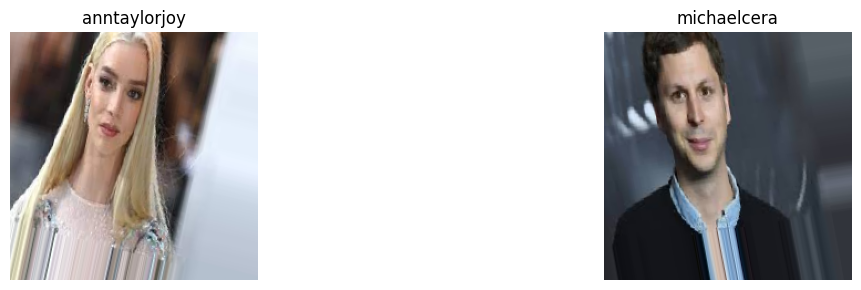

In [22]:
import matplotlib.pyplot as plt

batch = next(train_imgs)

class_labels = list(train_imgs.class_indices.keys())

num_classes = len(class_labels)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    class_indices = np.where(batch[1][:, i] == 1)[0]
    first_image_index = class_indices[0]
    first_image = batch[0][first_image_index]
    axes[i].imshow(first_image)
    axes[i].set_title(class_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import tensorflow as tf
model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model.trainable = False # Freeze the base model

# Add a fine-tuning layer
inputs = keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.Dense(2048, activation='relu')(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 2)                 4098      
                                                           

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 30
model.fit(train_imgs, epochs=epochs, validation_data=test_imgs)

Epoch 1/30
1/1 [==============================] - 45s 45s/step - loss: 0.6857 - accuracy: 0.5143 - val_loss: 3.2136 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 45s 45s/step - loss: 3.3131 - accuracy: 0.4857 - val_loss: 1.0699 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 45s 45s/step - loss: 0.9748 - accuracy: 0.5143 - val_loss: 0.9210 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 45s 45s/step - loss: 0.8398 - accuracy: 0.5143 - val_loss: 0.6103 - val_accuracy: 0.7500
Epoch 5/30
1/1 [==============================] - 45s 45s/step - loss: 0.6004 - accuracy: 0.6000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 45s 45s/step - loss: 0.6805 - accuracy: 0.4857 - val_loss: 0.6087 - val_accuracy: 0.6500
Epoch 7/30
1/1 [==============================] - 45s 45s/step - loss: 0.5933 - accuracy: 0.6000 - val_loss: 0.6018 - val_accuracy: 0.5500
Epoch 8/30
1/1 [===========

In [32]:
test_batch = next(test_imgs)
val_batch = next(val_imgs)

predictions = model.predict(test_batch[0])
predictions_val = model.predict(val_batch[0])


1/1 [==============================] - 10s 10s/step


In [65]:
y_pred = np.rint(predictions_val)
y_true = val_imgs.classes


1.0

In [68]:
# Create lists for storing the predictions and labels
predictions = []
labels = []

generator = test_imgs

# Get the total number of labels in generator
# (i.e. the length of the dataset where the generator generates batches from)
n = len(generator.labels)

# Loop over the generator
for data, label in generator:
    # Make predictions on data using the model. Store the results.
    predictions.extend(model.predict(data).flatten())

    # Store corresponding labels
    labels.extend(label)

    # We have to break out from the generator when we've processed
    # the entire once (otherwise we would end up with duplicates).
    if (len(label) < generator.batch_size) and (len(predictions) == n):
        break

1/1 [==============================] - 12s 12s/step


KeyboardInterrupt: ignored

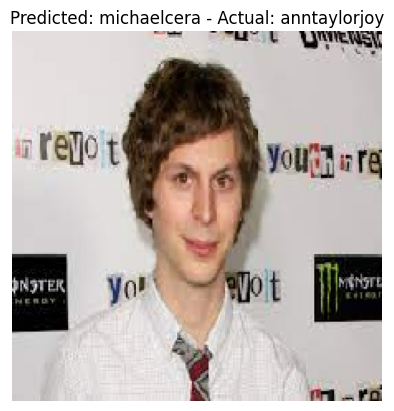

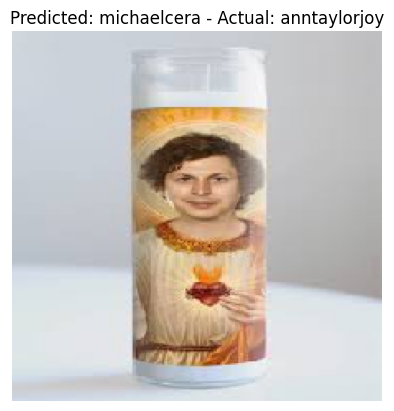

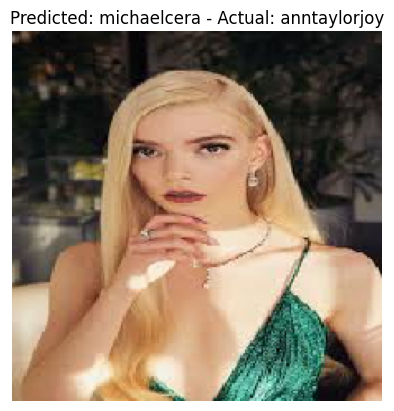

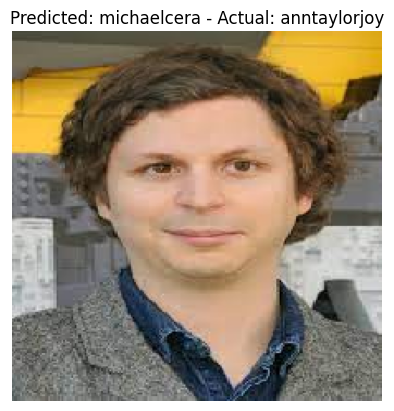

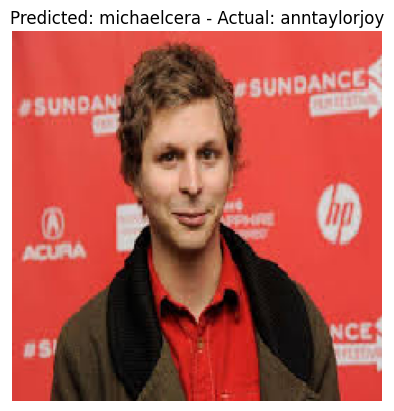

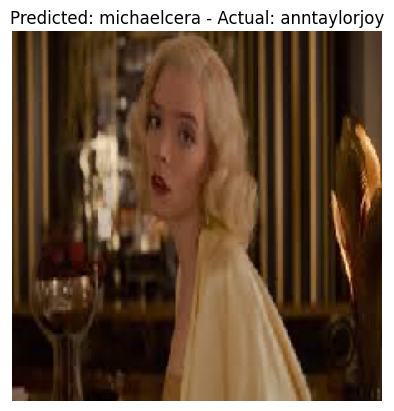

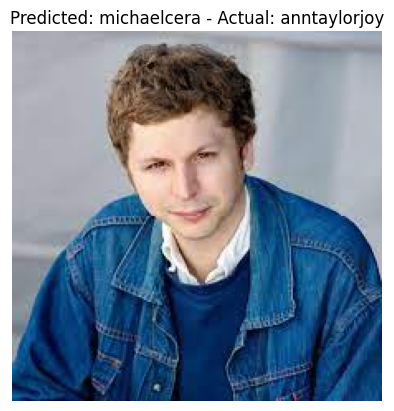

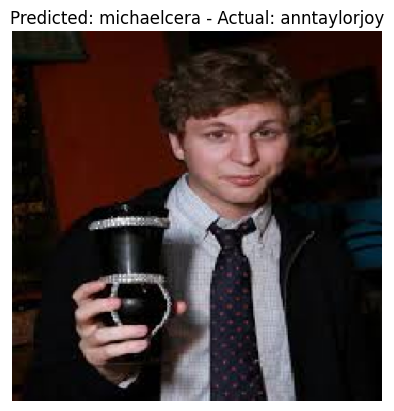

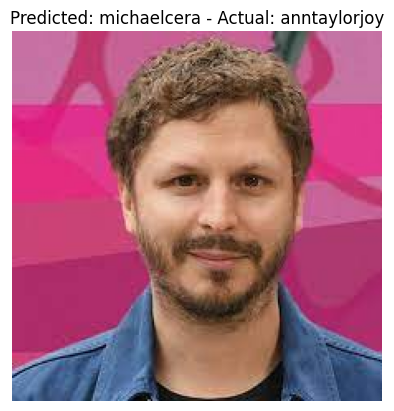

IndexError: ignored

In [66]:

for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]
    true_label = class_labels[np.argmax(y_true[idx])]
    if predicted_label != true_label:
      plt.imshow(test_batch[0][idx])
      plt.title(f"Predicted: {predicted_label} - Actual: {true_label}")
      plt.axis('off')
      plt.show()